# Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **"multiple** files, please do not forget to include all the files when submit. The list of files:
- This notebook
- assignment1_modules.ipynb
- assignment0_differentiation.ipynb

In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')


Bad key "xtick.alignment" on line 250 in
/usr/share/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "ytick.alignment" on line 268 in
/usr/share/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [2]:
"""
--------------------------------------
-- Tech note
--------------------------------------    
np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
for better memory handling

Suppose you allocated a variable    

    a = np.zeros(...)

So, instead of

    a = b + c  # will be reallocated, GC needed to free

I would go for: 

    np.add(b,c,out = a) # puts result in `a`

But it is completely up to you.
"""

'\n--------------------------------------\n-- Tech note\n--------------------------------------    \nnp.multiply, np.add, np.divide, np.subtract instead of *,+,/,-\nfor better memory handling\n\nSuppose you allocated a variable    \n\n    a = np.zeros(...)\n\nSo, instead of\n\n    a = b + c  # will be reallocated, GC needed to free\n\nI would go for: \n\n    np.add(b,c,out = a) # puts result in `a`\n\nBut it is completely up to you.\n'

In [2]:
# Note that every time you change assignment1_modules.ipynb, 
# you should run this cell to apply your changes
%run assignment1_modules.ipynb

[5.5 6.5 8.5]


Optimizer is implemented for you. 

In [2]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        Make this function faster if you can!
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            print(cur_old_grad)
            cur_old_grad = config['momentum'] * cur_old_grad + config['learning_rate'] * cur_dx
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            np.add(cur_x, -cur_old_grad, out=cur_x)
            i += 1     

Implement [**Adam optimizer**](https://arxiv.org/abs/1412.6980). Test and experiment it. Write your opinion.


In [3]:
def adam_optimizer(x, dx, config,state):
    """
        config:
            -alpha
            -beta1
            -beta2
            -epsilon
        state:
            -old_grad
    
    """
    
    
    alpha = config['alpha']
    beta1 = config['beta1']
    beta2 = config['beta2']
    epsilon = config['epsilon']
    i = state['t']
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            m = np.zeros_like(cur_x)
            v = np.zeros_like(cur_x)
            m = beta1*m + (1 - beta1)*cur_dx
            v = beta2*v + (1 - beta2)*(cur_dx**2)
            m_hat = m/(1 - beta1**i)
            v_hat = v/(1 - beta2**i)
            cur_old_grad = alpha*(m_hat/(np.sqrt(v_hat) + epsilon))
             
            np.add(cur_x, -cur_old_grad, out=cur_x)
    state['t'] += 1

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

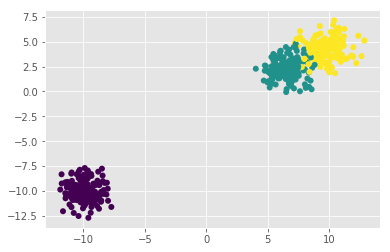

In [381]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

X, Y = make_blobs(n_samples=500, centers=3, n_features=2)
lb.fit(Y)
Y = lb.transform(Y)
# X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = np.argmax(Y, axis=1), edgecolors= 'none')


Define a **logistic regression** for debugging. 

In [382]:
%run assignment1_modules.ipynb

In [383]:
criterion = CrossEntropyCriterion()

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 3))
net.add(SoftMax())
net.train()

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [384]:
# Iptimizer params
optimizer_config = {'alpha': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
optimizer_config_sgd = {'learning_rate' : 0.1, 'momentum': 0.9}
state = {'t':1}


# Looping params
n_epoch = 20
batch_size = 200

In [10]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

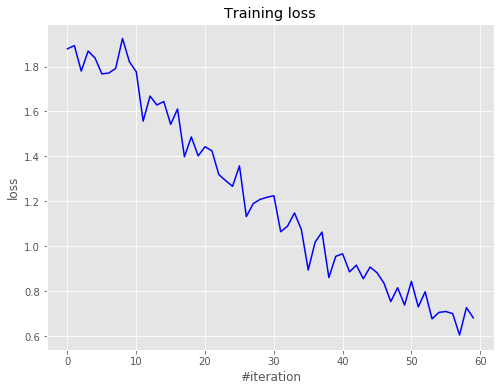

Current loss: 0.680860


In [386]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X, Y, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                    state
                     )      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [4]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [5]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
one_hot_y = enc.fit_transform(y.reshape(-1, 1)).todense()

one_hot_y = np.array(one_hot_y)

X_test = X[:7000]
y_test = y[:7000]

X_valid = X[7000:14000]
y_valid = one_hot_y[7000:14000]

X_train = X[14000:]
y_train = one_hot_y[14000:]

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchMeanSubtraction` between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchMeanSubtraction` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [6]:
%run assignment1_modules.ipynb

In [7]:
criterion = CrossEntropyCriterion()
criterion_b = CrossEntropyCriterion()
# Test something like that then 

net = Sequential()
net.add(Linear(784, 4))
net.add(SoftPlus())
net.add(Linear(4, 10))
net.add(SoftMax())

net_b = Sequential()
net_b.add(Linear(784, 4))
net_b.add(BatchMeanSubtraction())
net_b.add(SoftPlus())
net_b.add(Linear(4, 10))
net_b.add(SoftMax())
net_b.train()

print(net)
print(net_b)

Linear 784 -> 4
SoftPlus
Linear 4 -> 10
SoftMax

Linear 784 -> 4
BatchMeanNormalization
SoftPlus
Linear 4 -> 10
SoftMax



In [8]:
# Iptimizer params
optimizer_config = {'alpha': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
optimizer_state = {'t':1}
optimizer_state_b = {'t':1}

# Looping params
n_epoch = 20
batch_size = 1000

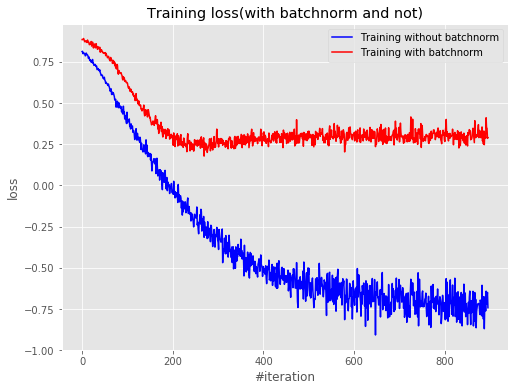

Current loss: 0.475899
Current loss with b: 1.335764


KeyboardInterrupt: 

In [12]:
loss_history = []
loss_history_b = []
for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
        net.zeroGradParameters()
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        
        # Backward

        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state_b)      
        
        loss_history.append(loss)
        
        # With batch norm.
        net_b.zeroGradParameters()
        predictions_b = net_b.forward(x_batch)
        loss_b = criterion_b.forward(predictions_b, y_batch)
        
        # Backward

        dp_b = criterion_b.backward(predictions_b, y_batch)
        net_b.backward(x_batch, dp_b)
        
        # Update weights
        adam_optimizer(net_b.getParameters(), 
                     net_b.getGradParameters(), 
                     optimizer_config,
                     optimizer_state_b)      
        
        loss_history_b.append(loss_b)
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss(with batchnorm and not)")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(np.log(loss_history), 'b',label = 'Training without batchnorm')
    plt.plot(np.log(loss_history_b), 'r',label = 'Training with batchnorm')
    plt.legend()
    plt.show()
    
    print('Current loss: %f' % loss)
    print('Current loss with b: %f' % loss_b)

The fastest one is Relu.The most beatiful plot was in Softplus). About BatchMeanSubtraction, it helps at the start of learning and loss was reduced faster.

Write your personal opinion on the activation functions, think about computation times too. Does `BatchMeanSubtraction` help?

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

In [427]:
criterion = CrossEntropyCriterion()

net = Sequential()
net.add(Linear(784, 32))
net.add(ReLU())
net.add(Linear(32, 10))
net.add(SoftMax())

print(net)

Linear 784 -> 32
ReLU
Linear 32 -> 10
SoftMax



In [428]:
# Iptimizer params
optimizer_config = {'alpha': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
state = {'t':1}
optimizer_state_new = {}

# Looping params
n_epoch = 4
batch_size = 200

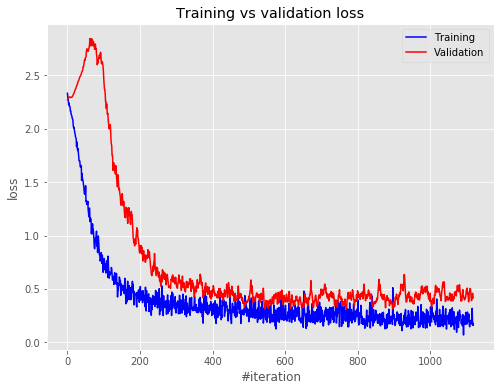

Current loss: 0.160373


In [429]:
loss_history = []
valid_loss = []
for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
        net.zeroGradParameters()
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        
        # Backward

        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                       state
                     )            
        
        loss_history.append(loss)
        
        pred = net.forward(X_valid)
        loss_valid = criterion.forward(pred, y_valid)
        
        valid_loss.append(loss_valid)
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training vs validation loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b',label = 'Training')
    plt.plot(valid_loss, 'r', label = 'Validation')
    plt.legend()
    plt.show()
    
    print('Current loss: %f' % loss)


Print here your accuracy. It should be around 90%.

We can see that validation loss is growing after 4th epoch.So lets do only 4 epochs.

In [430]:
predict = net.forward(X_test)

In [431]:
pr_logits = np.argmax(predict,axis=1)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pr_logits)

0.872

# Autoencoder (optional) 

This part is **OPTIONAL**, you may not do it. It will not be scored, but it is easy and interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
![](img/autoencoder.png)

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction. Use **BatchMeanNormalization** between **Linear** and **ReLU**. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [1]:
# Your code goes here. ################################################

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [2]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.

# Now optimize whole model
# Your code goes here. ################################################

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [3]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################

# Experiments (interesting) 

* Use ANN with one hidden layer for simple 1d regression problem (generate random points and fit your model on it).
Compare **Tanh** and **ReLu** activations for hidden layer (note that you do not need any nonlinearity for output layer). Also tweak hidden layer size.

* Train a multilayer model on MNIST and reach ~95% accuracy on test set. Now randomly remove neurons from your network (i.e. set neuron parameters zero). Plot test set accuracy versus number of neurons removed. Do the same expeiment with 1) Dropout layer added, 2) BatchMeanSubtraction layer added.

* Train a model on MNIST with multiclass criterion. Now backpropagate label throw network, i.e. find the input that would produce given output. Your label was one-hot-encoded (only one digit was on the picture). This time backpropagate label, which has 2 or more ones and see the input picture of the network.

In [252]:
a =  {}

In [254]:
a.setdefault('old',{})

{}

In [259]:
b = a['old'].setdefault(2,5)

In [269]:
b = 7

In [270]:
a

{'old': {2: 5}}